In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import scipy.stats
pitorch = torch.Tensor([math.pi])
import pickle
import pandas as pd
from pathlib import Path
from distmesh import *
from FEM_TPT import *
import controlled_traj, utils, rates
from utils import Ruggedmueller2

In [2]:
# run trajectories
model_10 = torch.load('./data/d-net_T10_2hidden40.pt')
model_10.eval()
beta = torch.tensor(1/10)
delt = torch.tensor(1e-5)
torch.manual_seed(100)
M = 250
cap_length = 200000
# I = controlled_traj.running_traj(cap_length,M,beta,delt,model_10)

In [3]:
# np.save('I_250_controlled_T10.npy', I)

In [420]:
data_type = 'T_accel'
# data_type = 'uniform'
# data_type = 'train_data'
beta_p = 1/20

In [463]:
if data_type == 'uniform':
    x = np.linspace(-1.5,1.2,400)
    y = np.linspace(-0.5,2,400)
    x_train, y_train = np.meshgrid(x,y)
    test_pts = torch.tensor(np.hstack((x_train.ravel()[:,None],y_train.ravel()[:,None])),\
                         dtype = torch.float32)

    rho_AB_NN, nu_AB_NN = rates.rates_uniformpts(test_pts, model_10, beta.item())
elif data_type == 'train_data':
    df = pd.read_excel('./data/traindata_meta_delta-net_T10.xlsx')

    X_train = pd.DataFrame(df['X'])
    Y_train = pd.DataFrame(df['Y'])

    X_train = torch.tensor(X_train.values,dtype=torch.float32)
    Y_train = torch.tensor(Y_train.values,dtype=torch.float32)

    test_pts = torch.cat((X_train, Y_train), 1)
    rho_AB_NN, nu_AB_NN = rates.rates_uniformpts(test_pts, model_10, beta.item())
elif data_type == 'T_accel':
    test_pts = torch.empty((1,2), dtype=torch.float32)
    for iter_ in range(10,11):
        print(iter_)
        pts = torch.load('./data/mueller_test_rho_T'+str(int(1/beta_p))+'_iter'+str(iter_)+'.pt')
        test_pts = torch.cat((test_pts, pts), axis = 0)
    test_pts = test_pts[1:,:]
    test_pts = test_pts.type(torch.float32)
    rho_AB_NN, nu_AB_NN = rates.rates_NNpts(test_pts, model_10, beta_p, beta.item()) 

    

10


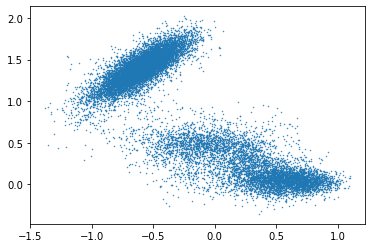

In [464]:
plt.scatter(test_pts[:,0].detach().numpy(), test_pts[:,1].detach().numpy(),s = 0.2)


In [465]:
# read file from sampled controlled trajectories
I = np.load('./data/I_250_controlled_T10.npy')
E_tau, E_tau_var, nu_AB_siml, lower, upper = rates.transition_rate_sample(1e-5,I,rho_AB_NN)

print('E_tau_AB: {:.4} with plus/minus {}'.format(E_tau, E_tau_var))
print('rho_AB using NN on {} pts: {:.4}'.format(data_type, rho_AB_NN))
print('transition rate for beta = 5 with TPT is {:.4}'.format(nu_AB_NN))
print('transition rate for beta = 5 with simulations is {:.4}'.format(nu_AB_siml))
print('confidence interval for transition rate is: [{:.4},{:.4}]'.format(lower, upper))

E_tau_AB: 0.05053 with plus/minus 0.004181064237374367
rho_AB using NN on T_accel pts: 0.000571
transition rate for beta = 5 with TPT is 0.007962
transition rate for beta = 5 with simulations is 0.0113
confidence interval for transition rate is: [0.01044,0.01232]


# Sampled path graph

In [6]:
# beta = torch.tensor(1/10)
# delt = torch.tensor(1e-5)
# torch.manual_seed(1998)
# X,Y,X_orig,Y_orig = controlled_traj.plot_traj(5000,3,beta,delt, model_10)
